In [1]:
from scipy.spatial.transform import Rotation as R
import numpy as np
import random
import cv2 

In [ ]:
np.log(0.01)/(np.log(1- (0.7)**4))

In [799]:
rot = R.from_euler('xyz',[1.25,1.29,0.73],degrees = True)

print(np.linalg.norm(rot.as_rotvec())*57)

1.923627562251257


In [627]:
R.from_euler?

In [2]:
def get_points_from_CAD():
    # we consider that marker has 40 mm length
# keypoints are defined from the CAD data
    """
    defines keypoints and holes' centers in marker CS
    """
    keypoints = np.zeros((14,2))
    i = 0
    keypoints[2*i] = [6.143, 37.51]
    keypoints[2*i+1] = [-keypoints[2*i][0], keypoints[2*i][1]]
    i+=1
    keypoints[2*i] = [27.213, 28.666]
    keypoints[2*i+1] = [-keypoints[2*i][0], keypoints[2*i][1]]
    i+=1
    keypoints[2*i] = [13.161, 26.86]
    keypoints[2*i+1] = [-keypoints[2*i][0], keypoints[2*i][1]]
    i+=1
    keypoints[2*i] = [27.707, 19.26]
    keypoints[2*i+1] = [-keypoints[2*i][0], keypoints[2*i][1]]
    i+=1
    keypoints[2*i] = [38.253, 5.53]
    keypoints[2*i+1] = [-keypoints[2*i][0], keypoints[2*i][1]]
    i+=1
    keypoints[2*i] = [19.9, -27.273]
    keypoints[2*i+1] = [-keypoints[2*i][0], keypoints[2*i][1]]
    i+=1
    keypoints[2*i] = [20.4, -29.39]
    keypoints[2*i+1] = [-keypoints[2*i][0], keypoints[2*i][1]]
    i+=1

    anchors = np.zeros((7,3))

    anchors[0] = [0.0, 0.0, 2.25]
    anchors[1] = [8.0, 11.2, 2.25]
    anchors[2] = anchors[1].copy()
    anchors[2][0] *= -1
    anchors[3] = [16.0, 0, 2.25]
    anchors[4] = anchors[3].copy()
    anchors[4][0] *= -1
    anchors[5] = [8.0, -13.86, 2.25]
    anchors[6] = anchors[5].copy()
    anchors[6][0] *= -1
    
    return keypoints, anchors[:,:2]

In [3]:
def to_rvec_tvec(tf):
    rvec = R.from_matrix(tf[:3,:3]).as_rotvec()
    tvec = tf[:3,3]
    return rvec,tvec    
    
def get_default_realsense_intrinsic():
    intr = np.eye(3, dtype=float)
    intr[0, 0] = 633.22
    intr[1, 1] = 632.515
    intr[0, 2] = 629.326
    intr[1, 2] = 360.888
    dist = np.array([[-0.0576521, 0.0680838, -0.000793749, 0.000349604, -0.021285]], dtype=float)

    return intr, dist

mtx, dist = get_default_realsense_intrinsic()
    
def get_camera_poses(dlin = 50, drot=0):
    rvec_ini = np.array([np.deg2rad(-1),np.deg2rad(1), np.pi + np.deg2rad(2)],dtype = np.float)
    tvec_ini = np.array([-2,1,160],dtype = np.float)
    
#     rvec_ini = np.array([0,0, np.pi],dtype = np.float)
#     tvec_ini = np.array([0,0,200],dtype = np.float)
    tf_ini = hom_tf(rvec_ini,tvec_ini)
    cam_rvecs_tvecs = [[rvec_ini,tvec_ini]]
    tfs = [np.eye(4)]
    tf_left = hom_tf(R.from_rotvec(np.array([0,np.deg2rad(-drot),0])).as_rotvec(),np.array([dlin,0.0,0.0]))
    tfs.append(tf_left)
#     print(tf_ini@tf_left)
    cam_rvecs_tvecs.append(to_rvec_tvec(tf_left@tf_ini))
    
    tf_right = hom_tf(R.from_rotvec(np.array([0,np.deg2rad(drot),0])).as_rotvec(),np.array([-dlin,0.0,0.0]))                 
    tfs.append(tf_right)
    cam_rvecs_tvecs.append(to_rvec_tvec(tf_right@tf_ini))
    
    tf_up = hom_tf(R.from_rotvec(np.array([np.deg2rad(drot),0,0])).as_rotvec(),np.array([0,dlin,0.0]))
    tfs.append(tf_up)
    cam_rvecs_tvecs.append(to_rvec_tvec(tf_up@tf_ini))
    
    tf_down = hom_tf(R.from_rotvec(np.array([np.deg2rad(-drot),0,0])).as_rotvec(),np.array([0,-dlin,0.0]))
    tfs.append(tf_down)
    cam_rvecs_tvecs.append(to_rvec_tvec(tf_down@tf_ini))
        
    return cam_rvecs_tvecs,tfs

In [4]:
def hom_tf(rvec,tvec):
    res = np.eye(4, dtype = np.float)
    res[:3,:3] = R.from_rotvec(rvec.flatten()).as_matrix()
    res[:3,3] = tvec.flatten()
    return res

def calc_error(reference_tf,rvecs,tvecs):
    res_tf = hom_tf(rvecs,tvecs)

    err = np.linalg.inv(reference_tf) @ res_tf
    theta = R.from_matrix(err[:3,:3]).as_rotvec()
    dt = err[:3,3]
    return np.rad2deg(theta), dt
        
points_3d,anchors = get_points_from_CAD()
points_3d = np.hstack((points_3d, np.zeros((points_3d.shape[0],1))))

cam_rvecs_tvecs,tfs = get_camera_poses()
for rvec,tvec in cam_rvecs_tvecs:
#     rvec,tvec = cam_rvecs_tvecs[0]
    cam_tf = hom_tf(rvec,tvec)
    projected_points, _ = cv2.projectPoints(points_3d, rvec, tvec, mtx, dist)
    _,rvecs, tvecs, _ = cv2.solvePnPRansac(points_3d, projected_points, mtx, dist)
    print(calc_error(cam_tf,rvecs,tvecs))

(array([ 3.99452481e-06, -6.19324222e-06,  1.23706137e-06]), array([-7.91545891e-07, -3.24107863e-07, -2.82957697e-06]))
(array([ 1.05280913e-05, -5.38992034e-08,  1.71710869e-06]), array([1.10898504e-06, 1.35725591e-06, 2.09784491e-06]))
(array([-7.96851599e-06,  5.36679743e-06,  1.25440935e-06]), array([ 1.38306925e-06, -8.78279142e-07,  5.09972054e-06]))
(array([-2.04865916e-05, -2.92270894e-06,  1.16447499e-06]), array([ 2.31929242e-06,  4.04589060e-06, -1.48548243e-05]))
(array([-1.23962603e-05,  1.17510582e-06, -2.02139229e-07]), array([1.02137030e-06, 4.91476345e-07, 7.01500596e-06]))


C:\Users\vikt-\AppData\Local\Temp/ipykernel_52804/2108698356.py:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  rvec_ini = np.array([np.deg2rad(-1),np.deg2rad(1), np.pi + np.deg2rad(2)],dtype = np.float)
C:\Users\vikt-\AppData\Local\Temp/ipykernel_52804/2108698356.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tvec_ini = np.array(

In [5]:
# generate poses
mu, sigma = 0, 0.8 # mean and standard deviation
s = np.random.normal(mu, sigma, 1)

all_poses = {}

np.random.seed(0)

i = 0
N_poses = 1500
for rvec,tvec in cam_rvecs_tvecs:
#     cam_tf = hom_tf(rvec,tvec)
    projected_points, _ = cv2.projectPoints(points_3d, rvec, tvec, mtx, dist)
#     _,rvecs, tvecs, _ = cv2.solvePnPRansac(points_3d, projected_points, mtx, dist)
    av_vals = []
    for iters in range(N_poses): 
        projected_points_copy = projected_points.copy()
        for pt in projected_points_copy:
            pt[0][0] += np.random.normal(mu, sigma, 1)
            pt[0][1] += np.random.normal(mu, sigma, 1)    
        ret,rvecs, tvecs, inliers = cv2.solvePnPRansac(points_3d, projected_points_copy, mtx, dist,iterationsCount = 50,
                                                       reprojectionError = sigma * 0.8 , flags = cv2.SOLVEPNP_SQPNP)

        if ret:
            av_vals.append([rvecs, tvecs])
    
    all_poses[i] = av_vals
    i+=1                     

16.772394883606545

In [6]:
def get_cam_i_in_robot():
    rvec = np.zeros(3)
    tvec = np.array([30,-200,300])
    
    return hom_tf(rvec,tvec)

tf_cam_i_in_robot = get_cam_i_in_robot()
rvec,tvec = cam_rvecs_tvecs[0]
cam_tf_ref = hom_tf(rvec,tvec)

sock_in_robot_tf_ref = tf_cam_i_in_robot @ cam_tf_ref

C:\Users\vikt-\AppData\Local\Temp/ipykernel_52804/2104487552.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  res = np.eye(4, dtype = np.float)


In [7]:
def get_random_pose_error(dt = 0,dr = 0):
    mu, sigma = 0, 0.33 # mean and standard deviation
    rot_axis = np.random.normal(mu, sigma, (3,1))
    rot_axis /= np.linalg.norm(rot_axis)
    
    sigma = dr/3
    rot_ange = np.deg2rad(np.random.normal(mu, sigma, 1))
    rvec = rot_ange * rot_axis
    
    sigma = (0.57 * dt)/3
    tvec = np.random.normal(mu, sigma, (3))
    rot_mtx =  hom_tf(rvec,tvec)
    return rot_mtx


def pick_random_poses(all_poses, n = 5):
    picked_poses = []
    for i in range(n):
        sample = random.sample(all_poses[i], 1)
        # моделируется ошибка прихода в позу камеры random_pose_error 
        from_cj_to_ci = np.linalg.inv(tfs[i])
        tf_socket_in_cam_j = hom_tf(sample[0][0],sample[0][1])
        
        robot_error = get_random_pose_error(1.0,1)
        tf_cam_i_in_robot = get_cam_i_in_robot()
        
        cam_j_in_robot = tf_cam_i_in_robot @ from_cj_to_ci
        cam_j_in_robot_with_error = cam_j_in_robot @ robot_error
        
        socket_in_robot = cam_j_in_robot_with_error @ tf_socket_in_cam_j
        
        rvec = R.from_matrix(socket_in_robot[:3,:3]).as_rotvec()
        picked_poses.append([rvec,socket_in_robot[:3,3]])
    
    picked_poses = np.array(picked_poses).reshape(-1,2,3)
    
    return picked_poses

def get_thresholds(k1 = 0.8,k2 = 0.8,k3=0.9):
    
    dy = k1 * 2.5
    dx = k2 *4
    dtheta_1 = k3* (3 + 2-2)
    dtheta_2 = k3* (4 + 1-1)
    dtheta_3 = k3* (1 )
    
    return dx,dy,dtheta_1,dtheta_2,dtheta_3

dx,dy,dtheta_1,dtheta_2,dtheta_3 = get_thresholds()

In [12]:
lin_errors = []
theta_errors = []
fail_lin = 0
fail_rot = 0

n_trials = 500
for i in range(n_trials):
    res = np.empty((0,2,3))
    for q in range(1):
        picked_poses = pick_random_poses(all_poses,n = 5)
        res = np.vstack((res,picked_poses))
    
    r = R.from_rotvec(res[:,0,:])
    averaged_tvec = res[:,1,:].mean(axis=0)
    rvec_mean = r.mean().as_rotvec()
    
    aver_tf_robot = hom_tf(rvec_mean,averaged_tvec)
    aver_tf_robot_error = aver_tf_robot @ get_random_pose_error(1.0,0.5)
    rvec,tvec = to_rvec_tvec(aver_tf_robot_error)
    
    theta, lin = calc_error(sock_in_robot_tf_ref,rvec,tvec)
    lin_errors.append(lin)
    theta_errors.append(theta)
#     print(theta)
    if (np.abs(theta[0]) > dtheta_1 or np.abs(theta[1]) > dtheta_2 or np.abs(theta[2]) > dtheta_3) :
        fail_rot +=1
    elif (np.abs(lin[0]) > dx 
        or np.abs(lin[1])>dy):
        fail_lin +=1
        
print("fail_lin", fail_lin, "fail_rot",fail_rot)
print("success rate",(n_trials*1.0 - (fail_lin+fail_rot))/n_trials)   

C:\Users\vikt-\AppData\Local\Temp/ipykernel_52804/2104487552.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  res = np.eye(4, dtype = np.float)


fail_lin 0 fail_rot 8
success rate 0.984


In [13]:
lin_errors = np.array(lin_errors)
print((lin_errors[:,]).mean(axis = 0))
print((lin_errors).std(axis = 0))

[ 0.01786598  0.02883377 -0.01126804]
[0.34311617 0.81233442 0.52161935]


In [15]:
print(np.linalg.norm((lin_errors[:,]),axis=1).mean())
print(np.linalg.norm(lin_errors,axis=1).std())

0.6482685171132959
0.7941839445441125


[ 0.05773503 -0.01540544 -0.18580164]
[ 0.36442445  0.12074125 -0.02401808]


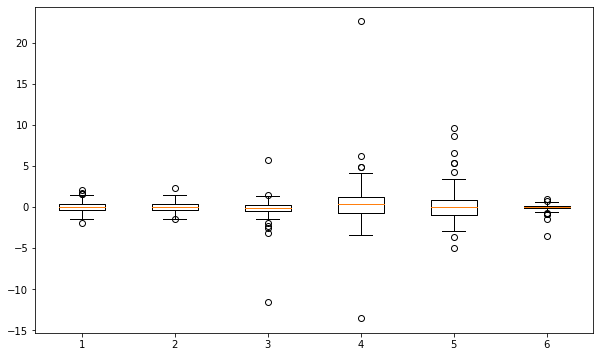

In [797]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Polygon

lin_errors = np.array(lin_errors)
theta_errors = np.array(theta_errors)
# print(np.linalg.norm((lin_errors[:,]),axis=1).mean())
# print(np.linalg.norm(theta_errors,axis=1).mean())
print((lin_errors[:,]).mean(axis = 0))
print((theta_errors).mean(axis = 0))

lin_errors = np.array(lin_errors)
fig, ax1 = plt.subplots(figsize=(10, 6))
# axs[0, 0].boxplot(data)
bp = ax1.boxplot([lin_errors[:,0],lin_errors[:,1],lin_errors[:,2],theta_errors[:,0],theta_errors[:,1],theta_errors[:,2]])
plt.show()

TypeError: list indices must be integers or slices, not tuple

0.6157043890654719
0.8460810136344971


In [752]:
print(np.linalg.norm((theta_errors[:,]),axis=1).mean())
print(np.linalg.norm(theta_errors,axis=1).std())

1.956970511904974
1.4142070050996114


TypeError: list indices must be integers or slices, not tuple

In [704]:
print(np.linalg.norm(theta_errors,axis=1).std())

0.555099734439868


In [696]:
print(np.abs((lin_errors[:,])).min(axis = 0))
print(theta_errors.min(axis = 0))

[0.00054739 0.00052274 0.00082165]
[-2.95862849 -2.96769992 -0.51364752]


In [687]:
theta_errors.std(axis=0)

array([0.64905331, 0.61487142, 0.16286226])

In [266]:
theta_errors

[array([ 3.11916607, -0.23680543,  0.06954612]),
 array([-3.83269696, -0.72217359,  0.36253608]),
 array([ 4.08470458,  0.83146971, -0.29975335])]

In [645]:
    res = np.empty((0,2,3))
#         res = np.vstack((res,selected_vals))
#     print(res.shape)
#     print(selected_vals.shape)
#     for rvec,tvec in selected_vals:
#         theta, lin = calc_error(sock_in_tool_tf_ref,rvec,tvec)

[]


In [33]:
np.seterr(all="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [877]:
# proper averaging

# random.seed(0)
n = 10
selected_vals = random.sample(av_vals, n)
selected_vals = np.array(selected_vals).reshape(-1,2,3)
print("non averaged")
for rvec,tvec in selected_vals:
    theta, lin = calc_error(cam_tf,rvec,tvec)
    print(np.linalg.norm(theta),np.linalg.norm(lin))

n = 30
print("averaged by n=",n)
for i in range(50):
    selected_vals = random.sample(av_vals, n)
    selected_vals = np.array(selected_vals).reshape(-1,2,3)
    # averaged_vals = .mean(axis=0)
    r = R.from_rotvec(selected_vals[:,0,:])
    averaged_tvec = selected_vals[:,1,:].mean(axis=0)

    theta, lin = calc_error(cam_tf,r.mean().as_rotvec(),averaged_tvec)
    print(np.linalg.norm(theta),np.linalg.norm(lin))
#     for val in selected_vals:
#         theta, lin = calc_error(cam_tf,val[0],val[1])
#         print(np.linalg.norm(theta),np.linalg.norm(lin))

non averaged
10.803241435533165 5.819105360033819
23.229846367974254 3.9251800318703665
7.328240895075587 1.248099073872448
22.63455486580416 14.917328021820625
13.360725972388778 2.172709545281357
8.274450622339987 0.4825710146519563
7.558082066452762 2.067305501554676
1.0171924207750753 3.4496551028104494
7.5783341777997695 2.2652313552557892
5.8404161916895765 2.5915355493887495
averaged by n= 30
0.3215253865604727 2.322411134542026
1.144347043906739 1.0865391192086598
2.457793847324411 2.156727471679635
3.141663222731513 1.0598936760620559
1.1407807142002462 1.2860448930811212
2.2329831667622284 0.9368114810913095
1.1989944164938284 0.7201067414457429
1.8489607151786092 0.962122821335573
0.584074735693399 1.2450250407840908
2.3507075662793624 0.3495257641750759
2.0349421328254604 0.7082405875935347
1.1869568101301073 0.7776439435346858
0.9181082074654122 1.407322202209906
1.2249628530069987 1.7830675827033153
3.3263544874572966 1.3137797394149398
1.4708073594632667 0.13873506448483

array([[[ 2.00778104e-03, -8.19065983e-03, -3.14145554e+00],
        [ 6.12723457e-03, -3.43252694e-02,  1.99909387e+02]],

       [[ 1.72551440e-02, -8.60777845e-03, -3.14083271e+00],
        [ 1.50817646e-02, -2.92494685e-02,  1.99978230e+02]],

       [[-6.24246057e-03,  5.88501835e-03,  3.14145512e+00],
        [-2.81078653e-03, -8.67498922e-04,  2.00144676e+02]],

       [[-6.09810121e-03, -1.06041879e-02, -3.14135620e+00],
        [-2.25581783e-02, -3.50171511e-02,  1.99901156e+02]],

       [[ 8.93795811e-03,  2.30094075e-03,  3.14140945e+00],
        [ 1.50958870e-04,  3.82557393e-03,  2.00086799e+02]]])

In [750]:
selected_vals.reshape(-1,2,3)[:,0,:]

array([[ 2.00778104e-03, -8.19065983e-03, -3.14145554e+00],
       [ 1.72551440e-02, -8.60777845e-03, -3.14083271e+00],
       [-6.24246057e-03,  5.88501835e-03,  3.14145512e+00],
       [-6.09810121e-03, -1.06041879e-02, -3.14135620e+00],
       [ 8.93795811e-03,  2.30094075e-03,  3.14140945e+00]])

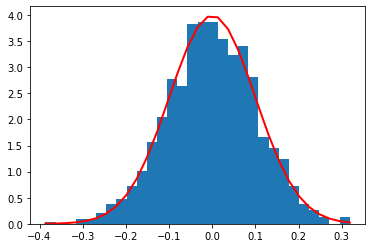

In [13]:
import matplotlib.pyplot as plt

mu, sigma = 0, 0.1 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)

count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.show()

mean = (1, 2)
cov = [[100, 0], [0, 1]]
x = np.random.multivariate_normal(mean, cov, (3, 3))

In [19]:
# cam_i_in_robot = np.eye(3)
# cam_i_in_robot[:,0] = np.array([0,1,0])
# cam_i_in_robot[:,1] = np.array([0,0,-1])
# cam_i_in_robot[:,2] = np.array([1,0,0])

# print(cam_i_in_robot)

[[-0.09478094 -0.01815164 -0.21254287]
 [ 0.03806207  0.03613243 -0.03807278]
 [ 0.0650917  -0.11140364 -0.16195075]]
